In [ ]:
import pandas as pd
import numpy as np

import konlpy
from konlpy.tag import Okt
tagger = Okt()

from collections import Counter

import gensim
from gensim.models import CoherenceModel
from gensim import corpora

import math
import warnings
warnings.filterwarnings('ignore')

In [ ]:
f1 = open('2020년 탈북학생 교육 우수사례집.txt', 'r')
lines20 = f1.readlines()
f1.close()

f2 = open('2021년 탈북학생 교육 우수사례집.txt', 'r')
lines21 = f2.readlines()
f2.close()

In [ ]:
final_lines = lines20 + lines21
final_lines2 = []
for sentences in final_lines:
    final_lines2.append(sentences.strip() )
print(final_lines2[:10])

['최우수상', '', 'THE 도!깨!비!(도전! 깨움! 비전!)', '', '송명희(송우초등학교)', '', 'THE 도!깨!비!(도전!  깨움!  비전!)  멘토링은 2년간 2명의 탈북학생 담임교사를 하며', '세운 탈북학생 멘토링 전략이다. 본교 탈북학생 맞춤형 멘토링은 도전, 깨움, 비전이라는', '약어로  학생들에게  생활  속에서  만나게  되는  문제나  기회들에  도전해보고,  그  문제를', '해결하는 과정에서 비약적인 깨움과 배움을 갖자는 약어이다. 또 이를 통해 행복 비전,']


In [ ]:
final_df = pd.DataFrame(final_lines2, columns=['data'])
print(len(final_df))

final_df.drop_duplicates(subset=['data'], inplace=True) #중복값 제거
print(len(final_df))

final_df['data'] = final_df['data'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')
final_df['data'].replace('', np.nan, inplace=True)
final_df.dropna(how='any', inplace=True)
print(len(final_df))
final_df

11808
6623
6270


,data
0,최우수상
2,도깨비도전깨움비전
4,송명희송우초등학교
6,도깨비도전깨움비전멘토링은년간명의탈북학생담임교사를하며
7,세운탈북학생멘토링전략이다본교탈북학생맞춤형멘토링은도전깨움비전이라는
...,...
11797,팩스
11799,홈페이지한국교육개발원
11801,탈북청소년교육지원센터
11803,인쇄처디자인범신


In [ ]:
stopwords = '은 는 이 가 을 를 저 대 학생 탈북 통해 위해 학년 내용 누리 진미 매우 상욱 무엇 또한 보고 중심 조금 하나 가지 정도 동생 한울이 면서 여주'
stopwords = stopwords.split(' ')

nouns = []
for sentences in final_df['data']:
    tokenized = tagger.nouns(sentences)
    stopped = [token for token in tokenized if token not in stopwords and len(token) > 1]
    nouns.extend(stopped)
nouns[:10]

['최우수상', '도깨비', '도전', '송명희송우', '초등학교', '도깨비', '도전', '멘토링', '명의', '담임']

In [ ]:
cnt_dic = Counter(nouns)
cnt_list = sorted(cnt_dic.items(), key=lambda x: x[1], reverse=True)
cnt_list[:10]

[('학교', 374),
 ('활동', 357),
 ('교육', 275),
 ('멘토링', 269),
 ('친구', 249),
 ('체험', 247),
 ('수업', 239),
 ('교사', 229),
 ('프로그램', 215),
 ('선생님', 211)]

In [ ]:
#빈도 데이터프레임 출력
cnt_df = pd.DataFrame(cnt_list, columns=['word', 'freq'])
cnt_df.index = cnt_df.index+1
cnt_df.to_excel('220316_탈북청소년우수사례_단어빈도분석(불용어제거).xlsx')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

%config InlineBackend.figure_fomat='retina'
!apt -qq -y install fonts-nanum
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=14)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


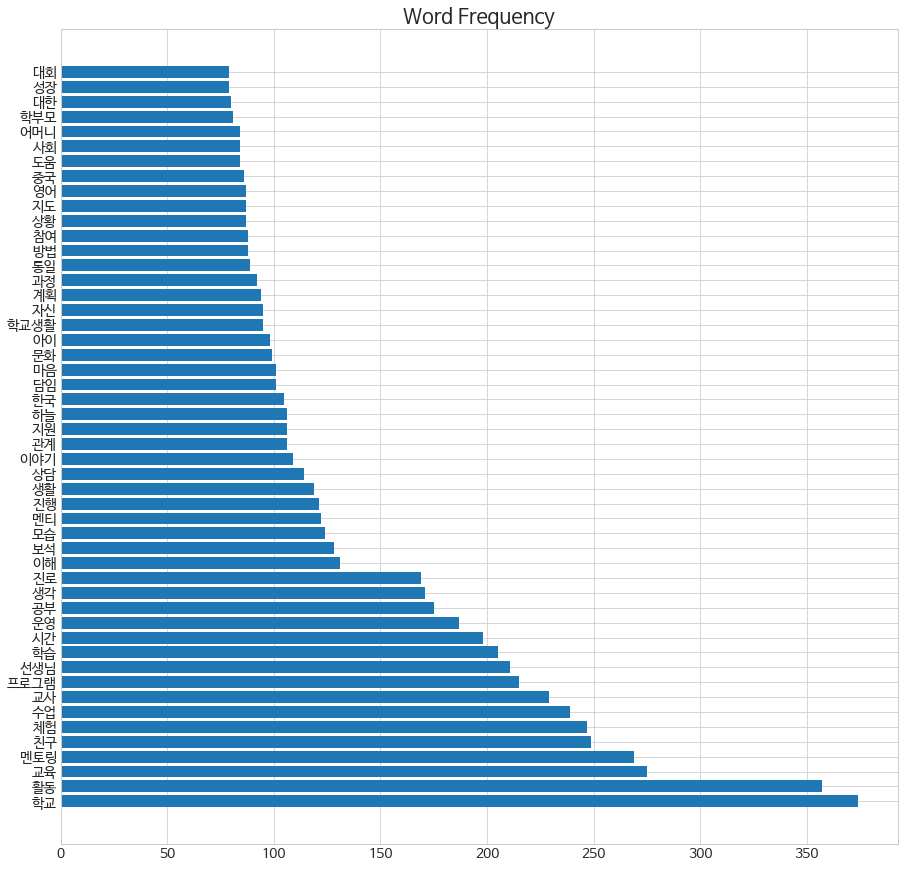

In [ ]:
top_50 = cnt_dic.most_common(50)
top_50 = dict(top_50)

x = top_50.values()
y = np.arange(len(top_50))

plt.figure(figsize=(15, 15))
plt.barh(y, x)

plt.title('Word Frequency', fontsize=20)
plt.yticks(y, top_50.keys(), fontsize=14)
plt.xticks(fontsize=14)

plt.savefig('220316_탈북청소년우수사례_word_frequency(불용어제거).png')
plt.show()

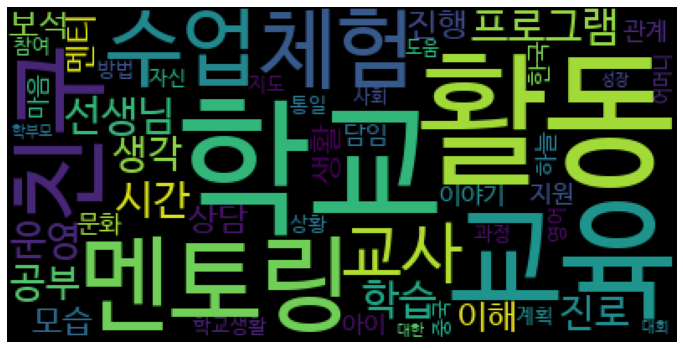

In [ ]:
#워드클라우드
!pip install wordcloud
from wordcloud import WordCloud

!pip install squarify
import squarify

wc = WordCloud(background_color='black', font_path=fontpath)
wc.generate_from_frequencies(top_50)

figure = plt.figure(figsize=(12, 12))
ax = figure.add_subplot(111)
ax.axis('off')

ax.imshow(wc);

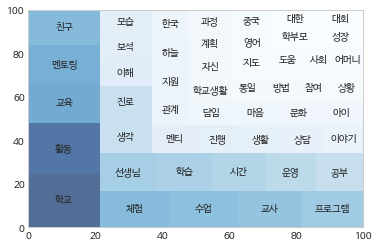

In [ ]:
#squarify
norm = mpl.colors.Normalize(vmin=min(top_50.values()),
                            vmax=max(top_50.values()))
colors = [mpl.cm.Blues(norm(value)) for value in top_50.values()]
squarify.plot(label = top_50.keys(),
              sizes = top_50.values(),
              color=colors,
              alpha=.7)
plt.grid()
plt.savefig('220316_탈북청소년우수사례_squarify(불용어제거).png')

#토픽모델링

In [ ]:
import nltk
from nltk import bigrams

In [ ]:
nouns2 = []
for line in lines_df['lines']:
    tokenized = tagger.nouns(line.strip().replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ''))
    stopped = [token for token in tokenized if token not in stopwords and len(token) > 1]
    nouns2.append(stopped)
nouns2

In [ ]:
bgrams = bigrams(nouns2)
dictionary = corpora.Dictionary(nouns2)
corpus = [dictionary.doc2bow(text) for text in nouns2]

n: 2 
coherence_score: 0.3695065634742351
n: 3 
coherence_score: 0.37810188313543813
n: 4 
coherence_score: 0.3619338272431592
n: 5 
coherence_score: 0.37848543727172823
n: 6 
coherence_score: 0.37587631242671304
n: 7 
coherence_score: 0.35780021407494705
n: 8 
coherence_score: 0.3697354611306946
n: 9 
coherence_score: 0.367113743369737
n: 10 
coherence_score: 0.36139814583750574


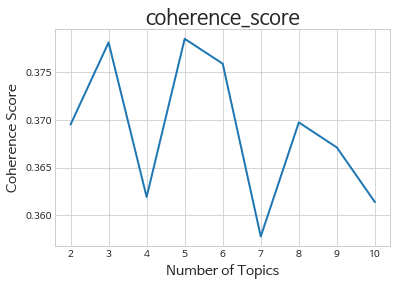

In [ ]:
from gensim.models import CoherenceModel
from gensim.models import LdaModel

coherence_values = []
for i in range(2, 11):
    ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=i)
    coherence_model_lda = CoherenceModel(ldamodel, texts=nouns2, corpus=corpus, dictionary=dictionary, topn=10)
    coherence_values.append(coherence_model_lda.get_coherence())
    print('n:', i, '\ncoherence_score:', coherence_model_lda.get_coherence())


fig = plt.plot(figsize=(15, 10))
plt.plot(range(2, 11), coherence_values, linewidth=2.0)
plt.title('coherence_score', fontsize=20)
plt.xlabel('Number of Topics', fontsize=14)
plt.ylabel('Coherence Score', fontsize=14)

plt.savefig('220316_탈북청소년우수사례_NumberOfTopics(불용어제거).png')
plt.show()

In [ ]:
#다시 토픽모델링 실시
Num_topics = int(input('토픽의 개수를 입력.: '))
Topics_w_num = int(input('출력할 토픽별 단어의 개수를 입력: '))

Random_state = 100
Update_every = 1
Chunksize = 100
Passes = 10
Alpha = 'auto'
Per_word_topics = True

ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=Num_topics,
                    random_state=Random_state, alpha=Alpha, passes=Passes, chunksize=Chunksize, )

topics = ldamodel.print_topics(num_words = Topics_w_num)
topics

토픽의 개수를 입력해 주세요.: 5
출력할 토픽별 단어의 개수를 입력해 주세요.: 10


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.001*"활동" + 0.001*"멘토링" + 0.001*"학교" + 0.001*"프로그램" + 0.001*"수업" + 0.001*"체험" + 0.001*"교사" + 0.001*"교육" + 0.001*"학습" + 0.001*"시간"'),
 (1,
  '0.001*"활동" + 0.001*"학교" + 0.001*"교육" + 0.001*"프로그램" + 0.001*"수업" + 0.001*"멘토링" + 0.001*"체험" + 0.001*"학습" + 0.001*"친구" + 0.001*"운영"'),
 (2,
  '0.001*"교육" + 0.001*"학교" + 0.001*"활동" + 0.001*"프로그램" + 0.001*"친구" + 0.001*"체험" + 0.001*"멘토링" + 0.001*"수업" + 0.001*"교사" + 0.001*"선생님"'),
 (3,
  '0.001*"활동" + 0.001*"학교" + 0.001*"교육" + 0.001*"친구" + 0.001*"프로그램" + 0.001*"체험" + 0.001*"멘토링" + 0.001*"시간" + 0.001*"진로" + 0.001*"수업"'),
 (4,
  '0.013*"활동" + 0.013*"학교" + 0.012*"교육" + 0.010*"멘토링" + 0.008*"친구" + 0.008*"수업" + 0.008*"체험" + 0.008*"프로그램" + 0.008*"교사" + 0.007*"선생님"')]

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)